## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

In [ ]:
recipe_mask = pd.read_csv('/content/RecipeDB_fivecui_mask.csv')
recipe_mask = recipe_mask.sample(frac=1, random_state=42).reset_index(drop=True)
ingredient_mask = pd.read_csv('/content/RecipeDB_ingredient_phrase_fivecui_masked.csv')

<ipython-input-161-881d6e24fa43>:1: DtypeWarning: Columns (3,6) have mixed types. Specify dtype option on import or set low_memory=False.
  recipe_mask = pd.read_csv('/content/RecipeDB_fivecui_mask.csv')


# Data Engineering
Here in this section, we will try to clean and process RecipeDB Five Cuisine dataset along with RecipeDB ingredient phrase dataset to create data for our prediction model.
For this, we will be going throught standard data processing techniques to check for data consistency.


1.   Check for null values in columns
2.   Check for non-related features



In [ ]:
# Now we are going to remove the non-relevant features from the dataset. Our intiuition is based on relevance of recipe with target Region

drop=['Recipe_title','url','Sub_region','Source','img_url','Sub_region','Continent','pescetarian', 'ovo_vegetarian',
       'lacto_vegetarian', 'ovo_lacto_vegetarian', 'ID1','Processes','Utensils','cook_time','prep_time','servings','total_time']
recipe_mask.drop(drop,axis=1,inplace=True)

In [ ]:
#Out of remaining features, check for null values in the dataset.
recipe_mask.isna().sum()

Recipe_id                          1470
Calories                              0
Region                                0
Carbohydrate, by difference (g)     415
Energy (kcal)                       415
Protein (g)                         415
Total lipid (fat) (g)               415
vegan                                 0
dtype: int64

In [ ]:
# We are going to remove specific rows with empty values in these particular columns
columns_to_check = ['Recipe_id','Carbohydrate, by difference (g)','Energy (kcal)','Protein (g)','Total lipid (fat) (g)']

# Drop rows with null values in the specified columns
recipe_mask = recipe_mask.dropna(subset=columns_to_check)

Since number of rows in recipe dataset in around 50,000, we will be going to sample the data on the basis of Region. The main reason is memory usage.

In [ ]:
# Sample 1/4 of examples of recipes based on Region
recipe_mask = recipe_mask.groupby('Region').apply(lambda x: x.sample(frac=0.25, random_state=42)).reset_index(drop=True)

In [ ]:
# List all the columns from Ingredient phrase dataset
ingredient_mask.columns

Index(['Recipe_id', 'ingredient_Phrase', 'ingredient', 'state', 'quantity',
       'unit', 'temp', 'df', 'size', 'ing_id', 'ndb_id', 'M_or_A'],
      dtype='object')

In [ ]:
# We will drop the irrelavant columns from the dataset as they will not be useful when we pivot the dataset
drop=['state', 'quantity',
       'unit', 'temp', 'df', 'size',]
ingredient_mask.drop(drop,axis=1,inplace=True)

In [ ]:
#We will check for null values in ingredient phrase dataset
ingredient_mask.isna().sum()

Recipe_id            14716
ingredient_Phrase        0
ingredient               0
ing_id                3024
ndb_id                   0
M_or_A                   0
dtype: int64

In [ ]:
# Columns to drop
columns_to_check = ['Recipe_id','ing_id']

# Drop rows with null values in the specified columns
ingredient_mask = ingredient_mask.dropna(subset=columns_to_check)

Now the most important section. As part of data augmentation, we will be merging the two datasets. The merge will be done on the basis of Recipe ID under **inner** join process.

In [ ]:
# Merge the dataset 1 and dataset 4 on 'Recipe ID'
df1 = pd.merge(recipe_mask, ingredient_mask, on='Recipe_id', how='inner')

In [ ]:
#Let's check if dataset is consistent in terms of null values
df1.isna().sum()

Recipe_id                          0
Calories                           0
Region                             0
Carbohydrate, by difference (g)    0
Energy (kcal)                      0
Protein (g)                        0
Total lipid (fat) (g)              0
vegan                              0
ingredient_Phrase                  0
ingredient                         0
ing_id                             0
ndb_id                             0
M_or_A                             0
dtype: int64

In [ ]:
#List of columns in merged dataset
df1.columns

Index(['Recipe_id', 'Calories', 'Region', 'Carbohydrate, by difference (g)',
       'Energy (kcal)', 'Protein (g)', 'Total lipid (fat) (g)', 'vegan',
       'ingredient_Phrase', 'ingredient', 'ing_id', 'ndb_id', 'M_or_A'],
      dtype='object')

Now, we will be creating a new dataframe with target variable **Region** and primary key **Recipe ID**. Since seperate set of processing will be required for merged dataset, we are storing information related to target variable so that information is not lost. We will later merge this into the main dataset on the basis of Recipe ID.

In [ ]:
# Create a new DataFrame with only 'Region' and 'Recipe_ID'
new_df = recipe_mask[['Recipe_id', 'Region','Calories','Carbohydrate, by difference (g)',
       'Energy (kcal)', 'Protein (g)', 'Total lipid (fat) (g)', 'vegan']].copy()

For creating a pivoted dataset, we will have to drop all the columns except **Recipe_id** and **ingredient**. Due to One-Many relation of Recipe and ingredients, a single Recipe_id has many ingredients mapped to it. This is not the right way to feed data into training the machine learning model. Hence, we will be pivoting the data so that each ingredient becomes a column and acts as an one hot encoded feature, where values will be stored in binary format.

In [ ]:
# Dropping columns as we have to pivot the dataset.
drop=['Calories','Carbohydrate, by difference (g)',
       'Energy (kcal)', 'Protein (g)', 'Total lipid (fat) (g)', 'vegan',
       'ingredient_Phrase','ing_id', 'ndb_id', 'M_or_A','Region']
df1.drop(drop,axis=1,inplace=True)

In [ ]:
# Now data is in right format
df1.head()

,Recipe_id,ingredient
0,118710.0,lite olive oil
1,118710.0,garlic
2,118710.0,zucchini
3,118710.0,green cabbage
4,118710.0,onion


In [ ]:
# new line
df2 = df1

In [ ]:
# Pivot the ingredients DataFrame
df1 = df1.pivot_table(index='Recipe_id', columns='ingredient', aggfunc=lambda x: 1, fill_value=0)

# Reset the index to make 'recipe_id' a regular column
df1.reset_index(inplace=True)

In [ ]:
df1.head()

ingredient,Recipe_id,',absolut citron vodka,accent flavor,accent seasoning,aceto balsamico,achar,achiote,achiote paste,achiote paste cube,...,yve meat substitution,yves,zapallo squash,zatarain black bean,zinfandel,ziti pasta,zucchini,zucchini blossom,zucchini chunk,zucchini lengthwise
0,100069.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,100093.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,100253.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,100367.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,100474.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now the data appears to be in the right format. We will also convert categorical values into numerical values

In [ ]:
# Identify object-type columns
object_cols = new_df.select_dtypes(include='object').columns

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to each object-type column and overwrite existing values
new_df[object_cols] = new_df[object_cols].apply(lambda col: label_encoder.fit_transform(col))

## Applying TF-IDF

We will be exploring TF-IDF approach as this can be mapped to Natural Language Processing (NLP) problem. Instead of words, we will be applying it to list of ingredients. TF-IDF will assign importance to set of most important ingredients which in turn can help the model to predict the Region.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Concatenate ingredients for each recipe
grouped_df = df2.groupby(['Recipe_id'])['ingredient'].agg(lambda x: ' '.join(x)).reset_index()

# Apply TF-IDF on the concatenated ingredients
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(grouped_df['ingredient'])

# Create a DataFrame with TF-IDF scores
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.insert(0, 'Recipe_id', grouped_df['Recipe_id'])

In [ ]:
# Copying TF-IDF data into dataframe
df1=tfidf_df

Since all the processing is done, we will merge the two datasets

In [ ]:
# Merge new_df with df1 on 'Recipe_id'
df1 = pd.merge(df1, new_df, on='Recipe_id', how='inner')

# Extract 'Region' into y
y = df1['Region']

# Drop 'Region' from df1
df1 = df1.drop('Region', axis=1)

# Machine Learning Model

In this section, we will be applying different sets of machine learning models on the prepared dataset. On the basis of validation, best working model will be selected which in turn will be fine tuned to give perfect results.

In [ ]:
# Creating copy of dataset as X
X = df1

In the last part of pre-processing, we will be apply **SMOTE** which is a sampling technique. Inorder to remove any kind of bias or discrepency in the model training, we will be sampling the data on the basis of target variable so that equal number of examples are generated for each class of target variable.

In [ ]:
# Apply SMOTE to the entire dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
# Perform train-test split on the resampled data with an 75-25 ratio
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

In [ ]:
# Calculate accuracy and print classification report
def accuracy_print(y_test,y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {accuracy:.2f}\n")
  print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# function to print cross-validation scores
from sklearn.model_selection import cross_val_score

def print_validation_scores(model, X, y, cv=5):
    """
    Print cross-validation scores for a given model.

    Parameters:
    - model: The machine learning model to be used.
    - X: Feature matrix.
    - y: Target variable.
    - cv: Number of cross-validation folds (default is 5).
    """
    # Apply cross-validation
    cv_scores = cross_val_score(model, X, y, cv=cv)

    # Display cross-validation scores
    print("Cross-Validation Scores:")
    print(cv_scores)
    print("Mean CV Score:", cv_scores.mean())

In [ ]:
def plot_multiclass_precision_recall_curve(model, X_test, y_test):
    """
    Plot Precision-Recall curves for each class in a multi-class classification scenario.

    Parameters:
    - model: Fitted classifier with predict_proba method.
    - X_test: Test features.
    - y_test: True labels for the test set.

    Returns:
    None (displays the plot)
    """
    # Make predictions on the test data (assuming y_pred contains probabilities for each class)
    y_scores = model.predict_proba(X_test)

    # Binarize the labels for each class
    y_test_bin = label_binarize(y_test, classes=range(model.n_classes_))

    # Compute Precision-Recall curve for each class
    precision = dict()
    recall = dict()
    pr_auc = dict()

    for i in range(model.n_classes_):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
        pr_auc[i] = auc(recall[i], precision[i])

    # Plot Precision-Recall curves for each class
    plt.figure(figsize=(8, 6))
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    for i, color in zip(range(model.n_classes_), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label=f'Class {i} (AUC = {pr_auc[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Cuisine Region Classification')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
def plot_multiclass_precision_recall_curve_log(model, X_test, y_test):
    """
    Plot Precision-Recall curves for each class in a multi-class classification scenario.

    Parameters:
    - model: Fitted classifier with predict_log_proba method.
    - X_test: Test features.
    - y_test: True labels for the test set.

    Returns:
    None (displays the plot)
    """
    # Make predictions on the test data (assuming y_pred contains log probabilities for each class)
    y_scores_log = model.predict_log_proba(X_test)

    # Convert log probabilities to probabilities
    y_scores = np.exp(y_scores_log)

    # Binarize the labels for each class
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

    # Compute Precision-Recall curve for each class
    precision = dict()
    recall = dict()
    pr_auc = dict()

    for i in np.unique(y_test):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
        pr_auc[i] = auc(recall[i], precision[i])

    # Plot Precision-Recall curves for each class
    plt.figure(figsize=(8, 6))
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    for i, color in zip(np.unique(y_test), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label=f'Class {i} (AUC = {pr_auc[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Cuisine Region Classification')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:

def plot_multiclass_roc_auc_curve(model, X_test, y_test):
    """
    Plot ROC-AUC curves for each class in a multi-class classification scenario.

    Parameters:
    - model: Fitted classifier with predict_proba method.
    - X_test: Test features.
    - y_test: True labels for the test set.

    Returns:
    None (displays the plot)
    """
    # Make predictions on the test data (assuming y_pred contains probabilities for each class)
    y_scores = model.predict_proba(X_test)

    # Binarize the labels for each class
    y_test_bin = label_binarize(y_test, classes=range(model.n_classes_))

    # Initialize lists to store fpr, tpr, and AUC values for each class
    fpr_list = []
    tpr_list = []
    auc_list = []

    # Compute ROC curve and AUC for each class
    for i in range(model.n_classes_):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        auc_list.append(roc_auc)

    # Plot ROC curves for each class
    plt.figure(figsize=(8, 6))
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    for i, color in zip(range(model.n_classes_), colors):
        plt.plot(fpr_list[i], tpr_list[i], color=color, lw=2,
                 label=f'Class {i} (AUC = {auc_list[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve for Cuisine Region Classification')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np

def plot_multiclass_roc_auc_curve_log(model, X_test, y_test):
    """
    Plot ROC-AUC curves for each class in a multi-class classification scenario using log probabilities.

    Parameters:
    - model: Fitted classifier with predict_log_proba method.
    - X_test: Test features.
    - y_test: True labels for the test set.

    Returns:
    None (displays the plot)
    """
    # Make predictions on the test data (assuming y_pred contains log probabilities for each class)
    y_scores_log = model.predict_log_proba(X_test)

    # Convert log probabilities to probabilities
    y_scores = np.exp(y_scores_log)

    # Binarize the labels for each class
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

    # Initialize lists to store fpr, tpr, and AUC values for each class
    fpr_list = []
    tpr_list = []
    auc_list = []

    # Compute ROC curve and AUC for each class
    for i in np.unique(y_test):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        auc_list.append(roc_auc)

    # Plot ROC curves for each class
    plt.figure(figsize=(8, 6))
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    for i, color in zip(np.unique(y_test), colors):
        plt.plot(fpr_list[i], tpr_list[i], color=color, lw=2,
                 label=f'Class {i} (AUC = {auc_list[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve for Multi-class Classification')
    plt.legend(loc='lower right')
    plt.show()

## Random Forest Classifier

Accuracy: 0.87

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.82      1019
           1       0.96      0.92      0.94      1027
           2       0.83      0.87      0.85       963
           3       0.86      0.87      0.86       952
           4       0.89      0.85      0.87       988

    accuracy                           0.87      4949
   macro avg       0.87      0.87      0.87      4949
weighted avg       0.87      0.87      0.87      4949

Cross-Validation Scores:
[0.79868654 0.74387472 0.9055317  0.90982571 0.89770144]
Mean CV Score: 0.8511240212174792


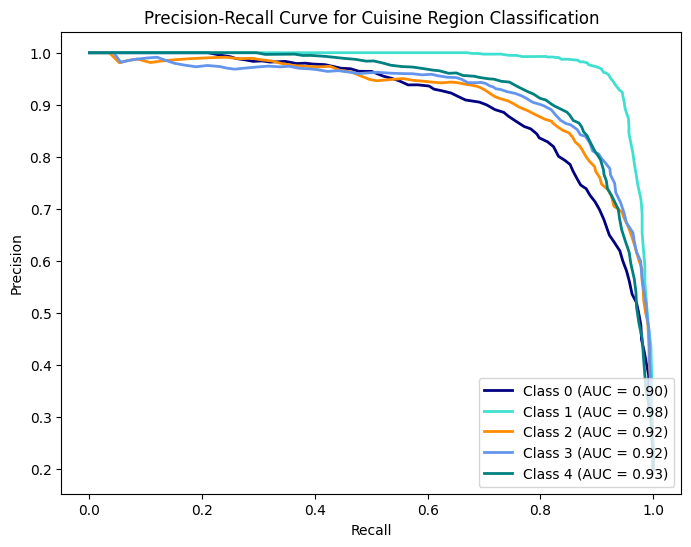

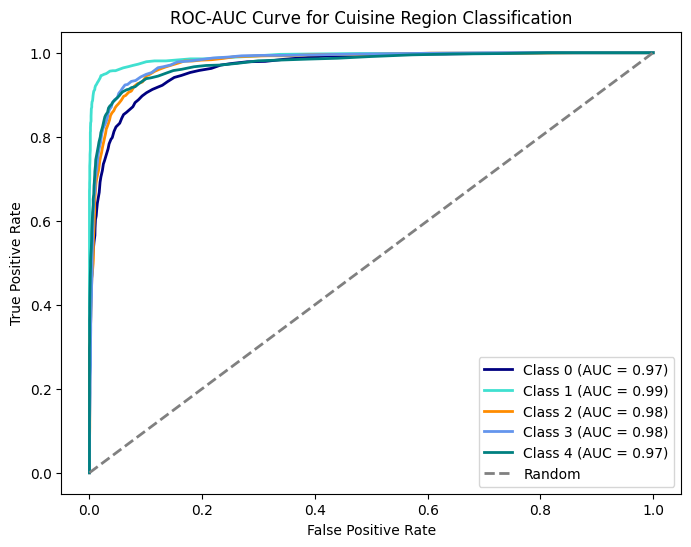

In [ ]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize model for cross-validation
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = rf_classifier.predict(X_test)

# Compute and display accuracy metrics
accuracy_print(y_test,y_pred_rf)

# Call cross-validation
print_validation_scores(model, X_resampled, y_resampled, cv=5)

# Call the function to plot Precision-Recall curve for multi-class classification
plot_multiclass_precision_recall_curve(rf_classifier, X_test, y_test)

# Call the function to plot ROC-AUC curve
plot_multiclass_roc_auc_curve(rf_classifier, X_test, y_test)

## Decision Tree Classifier

Accuracy: 0.76

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.70      0.69      1019
           1       0.90      0.85      0.88      1027
           2       0.73      0.73      0.73       963
           3       0.73      0.76      0.74       952
           4       0.77      0.74      0.75       988

    accuracy                           0.76      4949
   macro avg       0.76      0.76      0.76      4949
weighted avg       0.76      0.76      0.76      4949

Cross-Validation Scores:
[0.56958828 0.51199798 0.79464511 0.79616065 0.64258651]
Mean CV Score: 0.6629957059863603


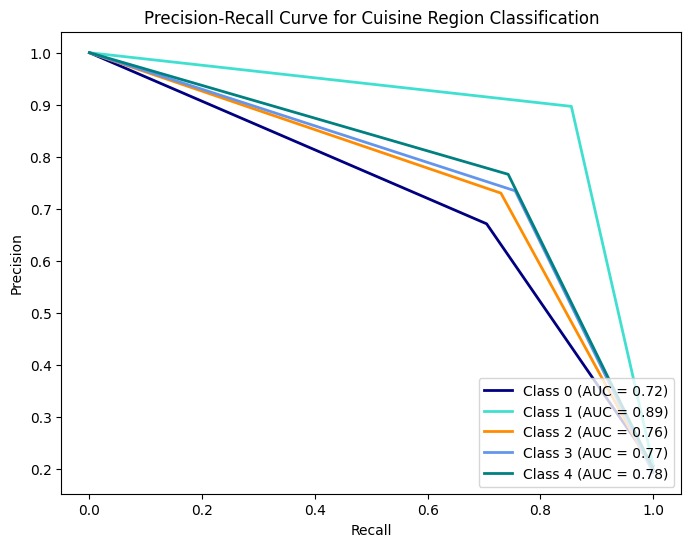

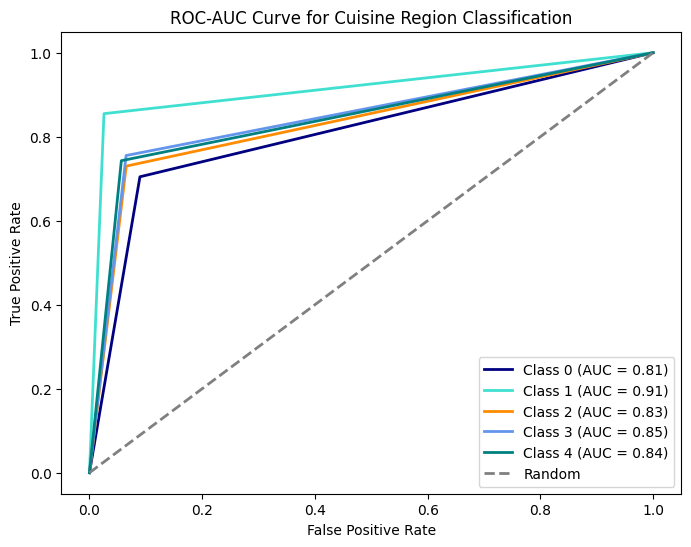

In [ ]:
# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the classifier on the training data
dt_classifier.fit(X_train, y_train)

# Initialize model for cross-validation
model = DecisionTreeClassifier(random_state=42)

# Make predictions on the test data
y_pred_dt = dt_classifier.predict(X_test)

# Compute and display accuracy metrics
accuracy_print(y_test,y_pred_dt)

# Call cross-validation
print_validation_scores(model, X_resampled, y_resampled, cv=5)

# Call the function to plot Precision-Recall curve for multi-class classification
plot_multiclass_precision_recall_curve(dt_classifier, X_test, y_test)

# Call the function to plot ROC-AUC curve
plot_multiclass_roc_auc_curve(dt_classifier, X_test, y_test)

# Gradient Boosting

Accuracy: 0.83

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.80      0.75      1019
           1       0.95      0.89      0.92      1027
           2       0.83      0.83      0.83       963
           3       0.86      0.82      0.84       952
           4       0.83      0.83      0.83       988

    accuracy                           0.83      4949
   macro avg       0.84      0.83      0.83      4949
weighted avg       0.84      0.83      0.84      4949

Cross-Validation Scores:
[0.7188684  0.66430917 0.84086891 0.83531195 0.69108361]
Mean CV Score: 0.7500884061631725


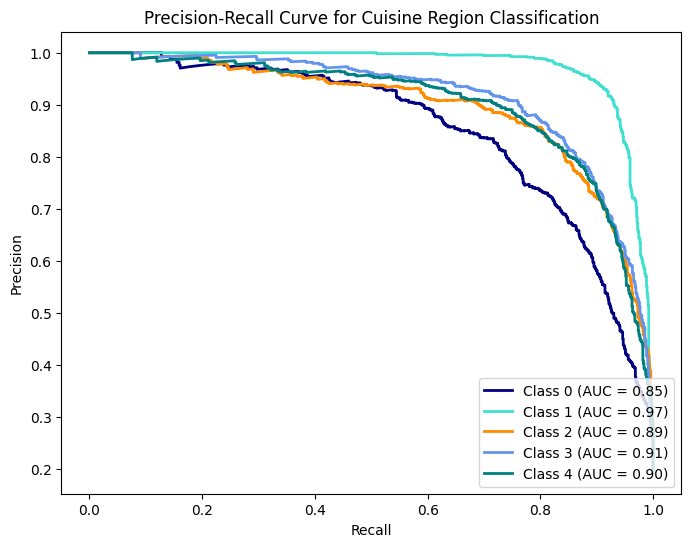

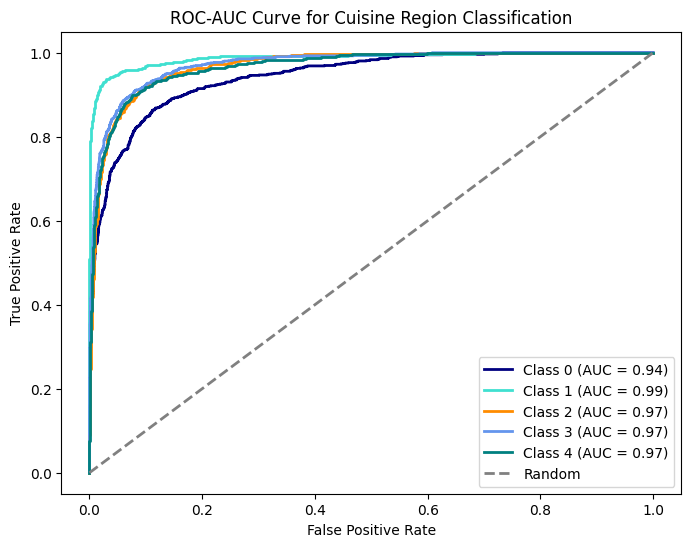

In [ ]:
# Initialize the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Train the classifier on the training data
gb_classifier.fit(X_train, y_train)

# Initialize model for cross-validation
model = GradientBoostingClassifier(random_state=42)

# Make predictions on the test data
y_pred_gb = gb_classifier.predict(X_test)

# Compute and display accuracy metrics
accuracy_print(y_test,y_pred_gb)

# Call cross-validation
print_validation_scores(model, X_resampled, y_resampled, cv=5)

# Call the function to plot Precision-Recall curve for multi-class classification
plot_multiclass_precision_recall_curve(gb_classifier, X_test, y_test)

# Call the function to plot ROC-AUC curve
plot_multiclass_roc_auc_curve(gb_classifier, X_test, y_test)

# Logistic Regression Classifier

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Accuracy: 0.22

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1019
           1       0.52      0.07      0.12      1027
           2       0.15      0.08      0.10       963
           3       0.00      0.00      0.00       952
           4       0.22      0.95      0.35       988

    accuracy                           0.22      4949
   macro avg       0.18      0.22      0.11      4949
weighted avg       0.18      0.22      0.11      4949



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Cross-Validation Scores:
[0.23162415 0.20586007 0.21747916 0.24981056 0.24602172]
Mean CV Score: 0.23015913109371056


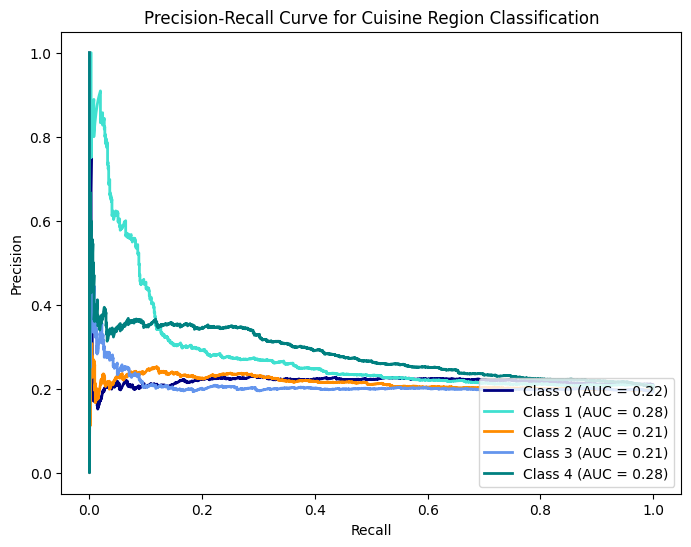

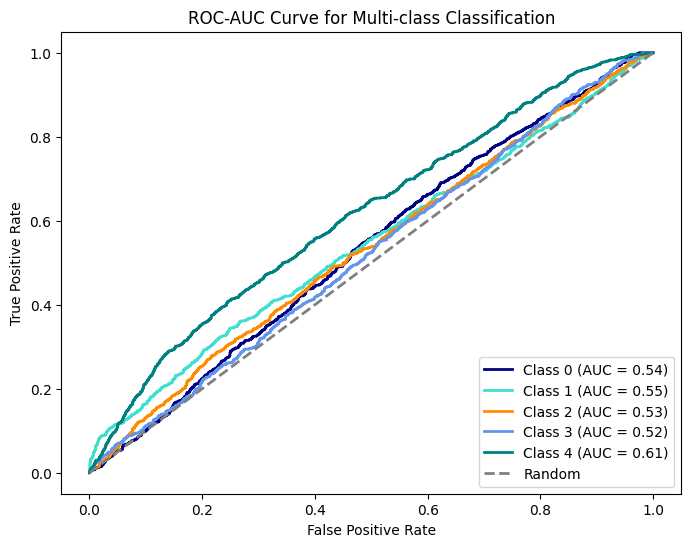

In [ ]:
# Initialize the Logistic Regression classifier
logreg_classifier = LogisticRegression(random_state=42)

# Train the classifier on the training data
logreg_classifier.fit(X_train, y_train)

# Initialize model for cross-validation
model_logreg = LogisticRegression(random_state=42)

# Make predictions on the test data
y_pred_logreg = logreg_classifier.predict(X_test)

# Compute and display accuracy metrics
accuracy_print(y_test, y_pred_logreg)

# Call cross-validation
print_validation_scores(model_logreg, X_resampled, y_resampled, cv=5)

# Call the function to plot Precision-Recall curve for multi-class classification
plot_multiclass_precision_recall_curve_log(logreg_classifier, X_test, y_test)

# Call the function to plot ROC-AUC curve
plot_multiclass_roc_auc_curve_log(logreg_classifier, X_test, y_test)

# Naive Bayes

Accuracy: 0.23

Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.77      0.34      1019
           1       0.41      0.11      0.17      1027
           2       0.19      0.08      0.11       963
           3       0.22      0.13      0.16       952
           4       0.24      0.03      0.06       988

    accuracy                           0.23      4949
   macro avg       0.25      0.22      0.17      4949
weighted avg       0.26      0.23      0.17      4949

Cross-Validation Scores:
[0.23137156 0.24829502 0.20939631 0.18994696 0.20308159]
Mean CV Score: 0.21641828744632483


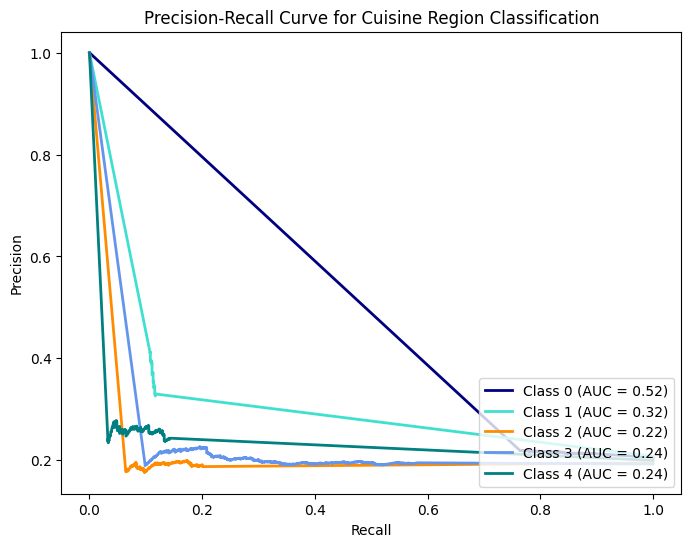

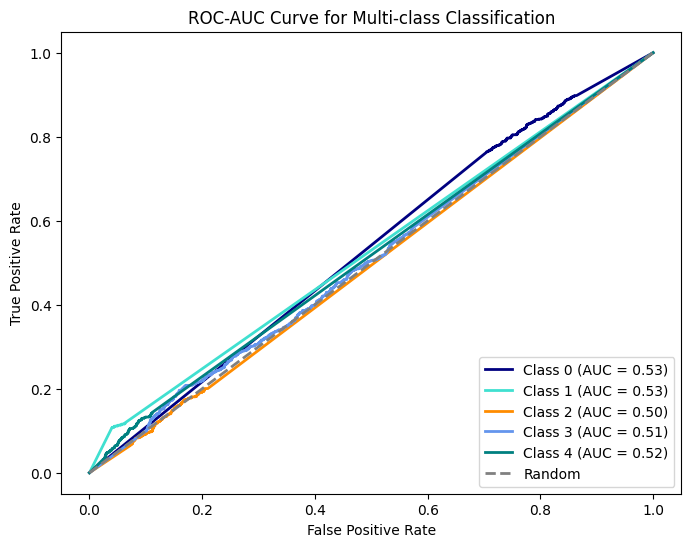

In [ ]:
# Initialize the Naive Bayes classifier (MultinomialNB)
nb_classifier = MultinomialNB()

# Train the classifier on the training data
nb_classifier.fit(X_train, y_train)

# Initialize model for cross-validation
model = MultinomialNB()

# Make predictions on the test data
y_pred_nb = nb_classifier.predict(X_test)

# Compute and display accuracy metrics
accuracy_print(y_test,y_pred_nb)

# Call cross-validation
print_validation_scores(model, X_resampled, y_resampled, cv=5)

# Call the function to plot Precision-Recall curve for multi-class classification
plot_multiclass_precision_recall_curve_log(nb_classifier, X_test, y_test)

# Call the function to plot ROC-AUC curve
plot_multiclass_roc_auc_curve_log(nb_classifier, X_test, y_test)

# Observation

Out of these five models, Random Forest is giving best results. We applied 5-fold cross validation to check for consistency of results. Mean value score of 85% is achieved using Random Forest

# Hyper-parameter tuning of best model

In [ ]:
from sklearn.model_selection import GridSearchCV

def perform_hyperparameter_tuning(X_train, y_train):
    """
    Perform hyperparameter tuning for the Random Forest classifier using Grid Search.

    Parameters:
    - X_train: Training features.
    - y_train: True labels for the training set.

    Returns:
    - best_params: Best hyperparameters found by Grid Search.
    - best_rf_model: Best Random Forest model based on the hyperparameter tuning.
    """

    # Define the parameter grid to search
    param_grid = {
        'n_estimators': [200, 500, 700],
        # 'max_depth': [None, 10, 20],
        # 'min_samples_split': [2, 5, 10],
        # 'min_samples_leaf': [1, 2, 4]
    }

    # Initialize the Random Forest classifier
    rf_classifier = RandomForestClassifier(random_state=42)

    # Initialize GridSearchCV with the specified parameter grid and cross-validation
    grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Get the best parameters from the grid search
    best_params = grid_search.best_params_

    # Get the best model from the grid search
    best_rf_model = grid_search.best_estimator_

    return best_params, best_rf_model

In [ ]:
# Perform hyperparameter tuning
best_params, best_rf_model = perform_hyperparameter_tuning(X_train, y_train)

# Print the best parameters
print("Best Parameters:", best_params)

# Train the best model on the training data
best_rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf_tuned = best_rf_model.predict(X_test)

# Evaluate the performance of the tuned model
accuracy_print(y_test,y_pred_rf_tuned)

Best Parameters: {'n_estimators': 700}
Accuracy: 0.87

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.82      1019
           1       0.96      0.92      0.94      1027
           2       0.84      0.87      0.85       963
           3       0.86      0.87      0.86       952
           4       0.89      0.85      0.87       988

    accuracy                           0.87      4949
   macro avg       0.87      0.87      0.87      4949
weighted avg       0.87      0.87      0.87      4949



In [ ]:
# Call cross-validation
model = RandomForestClassifier(n_estimators = 700, random_state=42)
print_validation_scores(model, X_resampled, y_resampled, cv=5)

Cross-Validation Scores:
[0.80247537 0.75903006 0.90603688 0.91184643 0.89719626]
Mean CV Score: 0.8553169992422328


#Conclusion
With hyperparameter tuning of n_estimators of Random Forest, we got a mean cross-validation score of **85.5%** which is **0.5%** better than base Random Forest model. Ensemble and Boosting algorithm seemed to outperform linear, probabilistic and tree based models. This is again confirmed by Precision and Recall curves.
